## LTS USC Data Analysis

The goal of this notebook is to analyze the data provided by the USC Shoah Foundation to the project *Let them Speak* and to offer quantitative insights into the data.

### Import the libraries needed

In [66]:
import sys; sys.path.insert(0, '..')
import pandas as pd
import os
from tqdm.notebook import tqdm
import constants
tqdm.pandas()
path = os.getcwd()
parent = os.path.abspath(os.path.join(path, os.pardir))


/miniconda3/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [67]:
from Utilities import mongo_helper
from Utilities import blacklab

### Load the necessary data into a panda dataframe

Get the testimonies metadata from the LTS database

In [68]:
collection = "USC"
db = "lts"
testimonies = mongo_helper.query(db,"testimonies",{'collection':collection},{'structured_transcript':0,'html_transcript':0,'_id':0})

In [69]:
df_testimonies = pd.DataFrame(testimonies)
df_testimonies =df_testimonies[df_testimonies['status']=="transcript_processed"]

In [70]:
if collection == "Fortunoff":
    additional_metadata=pd.read_csv(parent+'/Data/Output/'+'fortunoff_metadata.csv')
    df_testimonies = df_testimonies.merge(additional_metadata)
elif collection =="USC":
    additional_metadata=pd.read_csv(parent+'/Data/Output/'+'usc_metadata.csv')
    df_testimonies = df_testimonies.merge(additional_metadata)

In [71]:
def normalize_interview_codes(int_code):
    import re
    int_code = int_code.split('-')[1]
    x = re.split("^0*",int_code)
    if len(x)>1:
        return 'HVT-'+x[1]
    else:
        'HVT-'+x[0]

Add additional metadata to various collections

In [72]:
import json
if collection == "Fortunoff":
    metadata=open(parent+'/Data/Input/Fortunoff_Metadata/index.8.min.json')
    text = metadata.read()
    additional_metadata = json.loads(text)
    df_metadata = pd.DataFrame(additional_metadata)
    df_metadata = df_metadata[['id','birth_place_countries',]]
    df_metadata = df_metadata.rename(columns={"id": "testimony_id"})
    df_metadata['testimony_id'] = df_metadata.testimony_id.apply(normalize_interview_codes)
    df_testimonies = df_testimonies.merge(df_metadata,on='testimony_id')

### Print the number of testimonies that are processed and in the dataset

In [73]:
print (len(df_testimonies[df_testimonies['status']=="transcript_processed"]))

976


### Make a historiogram about the distribution of interview years

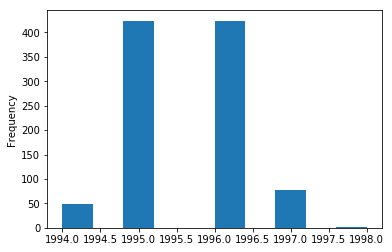

In [74]:
df_testimonies.recording_year.plot.hist()

### Print the earliest and latest interviews

In [75]:
df_testimonies.recording_year.max()

1998

In [76]:
df_testimonies.recording_year.min()

1994

### Print the average token number

In [77]:
def get_token_counts(testimony_id):
    result = blacklab.iterable_results('[]',lemma=False,path_to_phrase_model=None,window=0,document_ids=[testimony_id])
    tokens = [element for element in result]
    return (len(tokens))

In [ ]:
df_testimonies['word_count'] = df_testimonies.testimony_id.progress_apply(get_token_counts)

### Print the median token number

In [ ]:
df_testimonies['word_count'].median()

### Print the shortest interviews

In [ ]:
df_testimonies.sort_values('word_count')[0:5][['testimony_title','word_count']]

### Print the longest interviews

In [ ]:
df_testimonies.sort_values('word_count',ascending=False)[0:5][['testimony_title','word_count']]

### Print a histogram

In [ ]:
df_testimonies.word_count.plot.hist()

### Print the number of men and women interviewees

First, women:

In [ ]:
women = len(df_testimonies[(df_testimonies.gender=="female") & (df_testimonies.testimony_title.str.contains('and')==False)])

In [ ]:
print (women)

Second, men:

In [ ]:
men = len(df_testimonies[(df_testimonies.gender=="male") & (df_testimonies.testimony_title.str.contains('and')==False)])

In [ ]:
print (men)

In [ ]:
gender_plot = pd.DataFrame({'count':[women,men]},index=['women','men'])
plot = gender_plot.plot.pie(y='count', figsize=(5, 5))

In [ ]:
def identify_country_of_birth(text):
    import spacy
    import pycountry
    hist_countries = ["Yugoslavia",'Czechoslovakia','Russia']
    countries = [element.name for element in list(pycountry.countries)]
    countries.extend(hist_countries)
    born_sentence=[]
    nlp = spacy.load('en_core_web_sm') # Load the English Model
    doc = nlp(text)
    result = []
    for i,sent in enumerate(doc.sents):
        sentence_tokens = [token.text for token in sent]
        if "born" in sentence_tokens:
            labels = [token.text for token in sent]
            doc = nlp(' '.join(labels))
            if doc.ents:
                for element in doc.ents:
                    if (element.text in countries):
                        result.append(element.text)
            break
        if i==3:
            break
    if len(result)==1:
        return result[0]
    elif len(result)>1:
        return "fuzzy"
    else:
        return None

In [ ]:
#df_testimonies['country_of_birth'] = df_testimonies.interview_summary.progress_apply(identify_country_of_birth)

### Visualize the distribution of year of births

In [ ]:
df_testimonies['interviewee_year_of_birth']= pd.to_numeric(df_testimonies.interviewee_year_of_birth,errors='coerce')

In [ ]:
df_testimonies.interviewee_year_of_birth.plot.hist()

In [ ]:
df_testimonies[df_testimonies.gender=="female"].interviewee_year_of_birth.plot.hist()

In [ ]:
df_testimonies[df_testimonies.gender=="male"].interviewee_year_of_birth.plot.hist()

In [ ]:
women = df_testimonies[df_testimonies.gender=="female"][['interviewee_year_of_birth']]
men = df_testimonies[df_testimonies.gender=="male"][['interviewee_year_of_birth']]
#df = pd.DataFrame([women,men],index=['women','men'])

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.distplot(men[['interviewee_year_of_birth']].dropna(), hist=True, rug=False,label="Men")
sns.distplot(women[['interviewee_year_of_birth']].dropna(), hist=True, rug=False,label = 'Female')

In [ ]:
df_testimonies.interviewee_year_of_birth.min()

In [ ]:
df_testimonies.interviewee_year_of_birth.mean()

### Study the age of interviewee when interview given

In [ ]:
df_testimonies['age_interview_year']=df_testimonies['recording_year']-df_testimonies['interviewee_year_of_birth']

In [ ]:
df_testimonies['age_interview_year'].plot.hist()

In [ ]:
df_testimonies['age_interview_year'].mean()

## Look at the distribution of countries of birth of interviewees

In [ ]:
df_testimonies.birth_place_countries.value_counts()

## Render the Interview Locations

In [ ]:
df_testimonies.interview_location.value_counts()